In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import json
from tensorflow import keras
from keras import layers
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-29 15:35:19.369072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 15:35:19.369122: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 15:35:19.369144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 15:35:19.373260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-29 15:35:20.522283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 15:35:20.525096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 15:35:20.525129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
N = 10
T = 128
D = 0.1

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def shuffle(data, *args):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [5]:
input_data = []
input_label = []

for i in range(15000):
    alpha = np.random.uniform(low=0.001, high=1.999)
    #alpha = np.random.choice([0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.99], 1)[0]
    trajs_model, labels_model = models_phenom().single_state(N=N,
                                                            L=None,
                                                            T=T,
                                                            alphas=alpha,  # Fixed alpha for each state
                                                            Ds=[D, 0],# Mean and variance of each state
                                                           )
    for n_traj in range(N):
        xs = trajs_model[:, n_traj, 0]
        ys = trajs_model[:, n_traj, 1]

        xs = xs / (np.std(xs))
        xs = np.cumsum(abs(uncumulate(xs))) / T
        ys = ys / (np.std(ys))
        ys = np.cumsum(abs(uncumulate(ys))) / T

        input_data.append( (xs + ys) /2 )
        input_label.append(alpha)

(array([600., 780., 690., 840., 710., 560., 720., 680., 790., 840., 770.,
        730., 650., 650., 810., 780., 760., 670., 850., 790., 660., 700.,
        700., 780., 770., 890., 780., 810., 810., 820., 660., 710., 870.,
        790., 750., 750., 790., 590., 720., 590., 750., 860., 760., 690.,
        720., 900., 760., 820., 950., 640., 660., 720., 850., 620., 790.,
        740., 720., 800., 770., 590., 870., 720., 740., 790., 690., 760.,
        800., 850., 610., 610., 710., 750., 730., 680., 680., 680., 740.,
        640., 690., 660., 770., 750., 780., 770., 620., 710., 910., 630.,
        820., 770., 650., 700., 890., 890., 810., 900., 760., 810., 820.,
        750., 790., 970., 630., 790., 740., 750., 800., 800., 690., 630.,
        820., 560., 730., 760., 780., 700., 790., 600., 860., 760., 580.,
        750., 710., 640., 760., 770., 820., 850., 750., 790., 820., 730.,
        740., 830., 640., 830., 840., 720., 830., 860., 790., 640., 800.,
        730., 760., 690., 810., 780., 

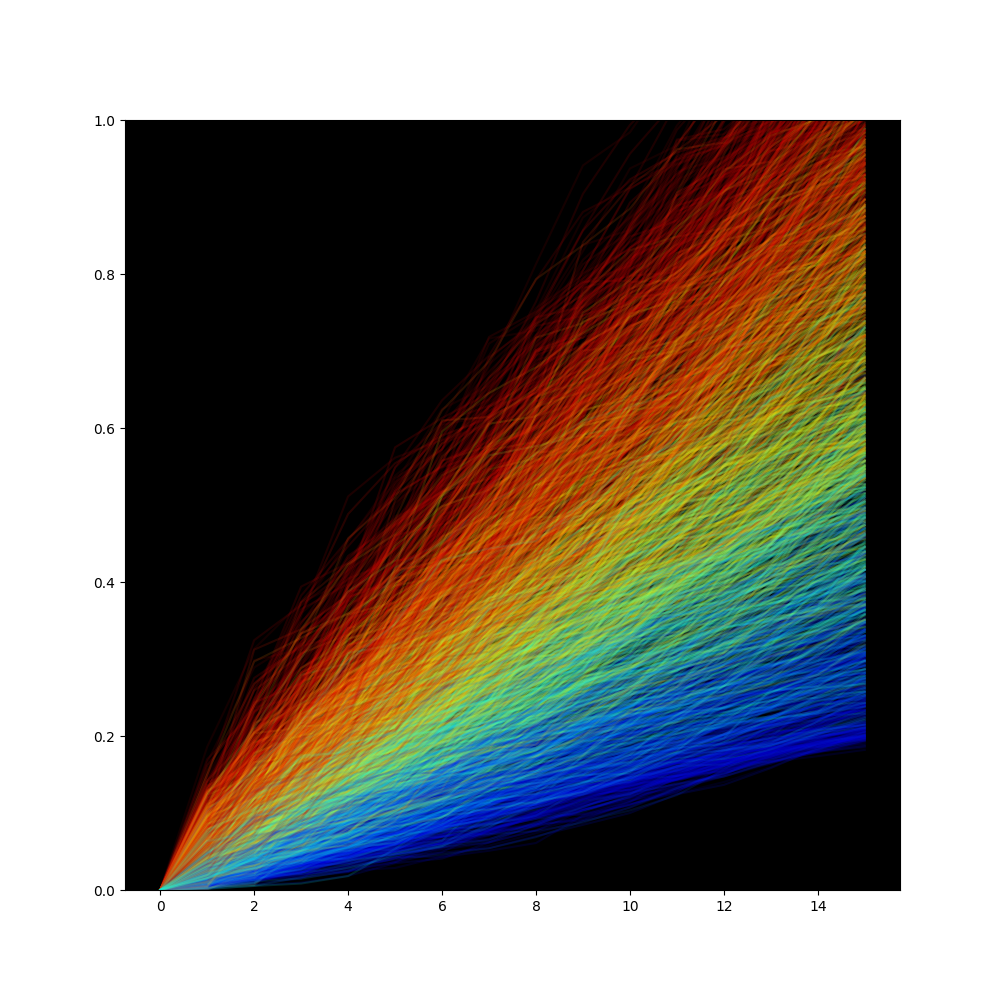

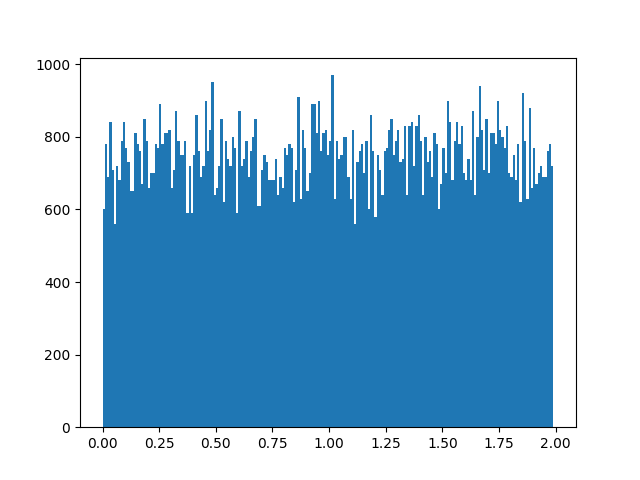

In [6]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

for i in range(0, 2000):
    color = color_seq[int(input_label[i]/2. * 255)]
    ax.plot(input_data[i], color=color, alpha=0.15, zorder=-1)
#ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.figure()
plt.hist(input_label, bins=np.arange(0, 2, 0.01))

In [7]:
input_data = np.array(input_data).reshape(-1, 1, T, 1)
input_label = np.array(input_label).reshape(-1, 1)
input_data, input_label = shuffle(input_data, input_label)

train_input = input_data[:int(input_data.shape[0] * 0.8)]
train_label = input_label[:int(input_data.shape[0] * 0.8)]
val_input = input_data[int(input_data.shape[0] * 0.8):]
val_label = input_label[int(input_data.shape[0] * 0.8):]

train_input, train_label = shuffle(train_input, train_label)
val_input, val_label = shuffle(val_input, val_label)

In [8]:
print(f'train_reg_shape:{train_input.shape}\n',
      f'train_label_shape:{train_label.shape}\n'
      f'val_reg_shape:{val_input.shape}\n',
      f'val_label_shape:{val_label.shape}\n'
     )

train_reg_shape:(120000, 1, 16, 1)
 train_label_shape:(120000, 1)
val_reg_shape:(30000, 1, 16, 1)
 val_label_shape:(30000, 1)



In [12]:
# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(1, None, 1), name="reg_signals")


x = layers.ConvLSTM1D(filters=32, kernel_size=2, strides=1, padding='same', dropout=0.1)(reg_input)
x = layers.ReLU()(x)
x = layers.Bidirectional(layers.LSTM(32, dropout=0.1))(x)

x = layers.Flatten()(x)
reg_dense = layers.Dense(units=2, activation='relu')(x)
reg_last_layer = layers.Dense(units=1)(reg_dense)

reg_model = keras.Model(
    inputs=[reg_input],
    outputs=[reg_last_layer],
    name='anomalous_regression'
)

In [13]:
reg_model.compile(loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3/2),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ]
                 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=50,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  start_from_epoch=15
                                                 )

In [14]:
reg_history = reg_model.fit(x=train_input,
                        y=train_label,
                        validation_data=(val_input, val_label),
                        batch_size=1024,
                        epochs=1500,
                        shuffle=True,
                        callbacks=[early_stopping],
                        verbose=2
                       )
reg_model.save(f'./models/reg_model_{T}.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_{T}.json', 'w'))

Epoch 1/1500
118/118 - 15s - loss: 0.7363 - MAE: 0.7017 - val_loss: 0.3314 - val_MAE: 0.4982 - 15s/epoch - 125ms/step
Epoch 2/1500
118/118 - 11s - loss: 0.3308 - MAE: 0.4984 - val_loss: 0.3144 - val_MAE: 0.4862 - 11s/epoch - 91ms/step
Epoch 3/1500
118/118 - 11s - loss: 0.1475 - MAE: 0.3064 - val_loss: 0.1056 - val_MAE: 0.2675 - 11s/epoch - 90ms/step
Epoch 4/1500
118/118 - 11s - loss: 0.0393 - MAE: 0.1550 - val_loss: 0.0201 - val_MAE: 0.1162 - 11s/epoch - 89ms/step
Epoch 5/1500
118/118 - 11s - loss: 0.0170 - MAE: 0.1059 - val_loss: 0.0139 - val_MAE: 0.0941 - 11s/epoch - 91ms/step
Epoch 6/1500
118/118 - 11s - loss: 0.0139 - MAE: 0.0932 - val_loss: 0.0125 - val_MAE: 0.0872 - 11s/epoch - 90ms/step
Epoch 7/1500
118/118 - 11s - loss: 0.0129 - MAE: 0.0883 - val_loss: 0.0119 - val_MAE: 0.0840 - 11s/epoch - 91ms/step
Epoch 8/1500
118/118 - 11s - loss: 0.0125 - MAE: 0.0858 - val_loss: 0.0123 - val_MAE: 0.0841 - 11s/epoch - 90ms/step
Epoch 9/1500
118/118 - 11s - loss: 0.0123 - MAE: 0.0844 - val_l

In [12]:
regression_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{T}.keras')

In [13]:
pred = regression_model.predict(val_input)
print(f'MAE_valid: {np.mean(abs(pred - val_label))}')
grid = np.arange(0, 2, 0.1)
H, xedges, yedges = np.histogram2d(val_label.flatten(), pred.flatten(), bins=(grid, grid))
print(np.hstack((val_label[:10], pred[:10])))

938/938 [==============================] - 5s 5ms/step
MAE_valid: 0.21457519914577067
[[1.10044461 1.19079983]
 [1.31754259 1.42643225]
 [1.9682864  1.83871019]
 [0.46356548 0.47197074]
 [1.44321003 1.37801039]
 [1.37286846 1.29585874]
 [1.26760717 1.36815548]
 [0.9832897  1.28737819]
 [0.45423582 0.34144801]
 [1.50136839 1.16267478]]


[Text(0.5, 126.44444444444441, 'True alpha'),
 Text(169.44444444444446, 0.5, 'Pred alpha')]

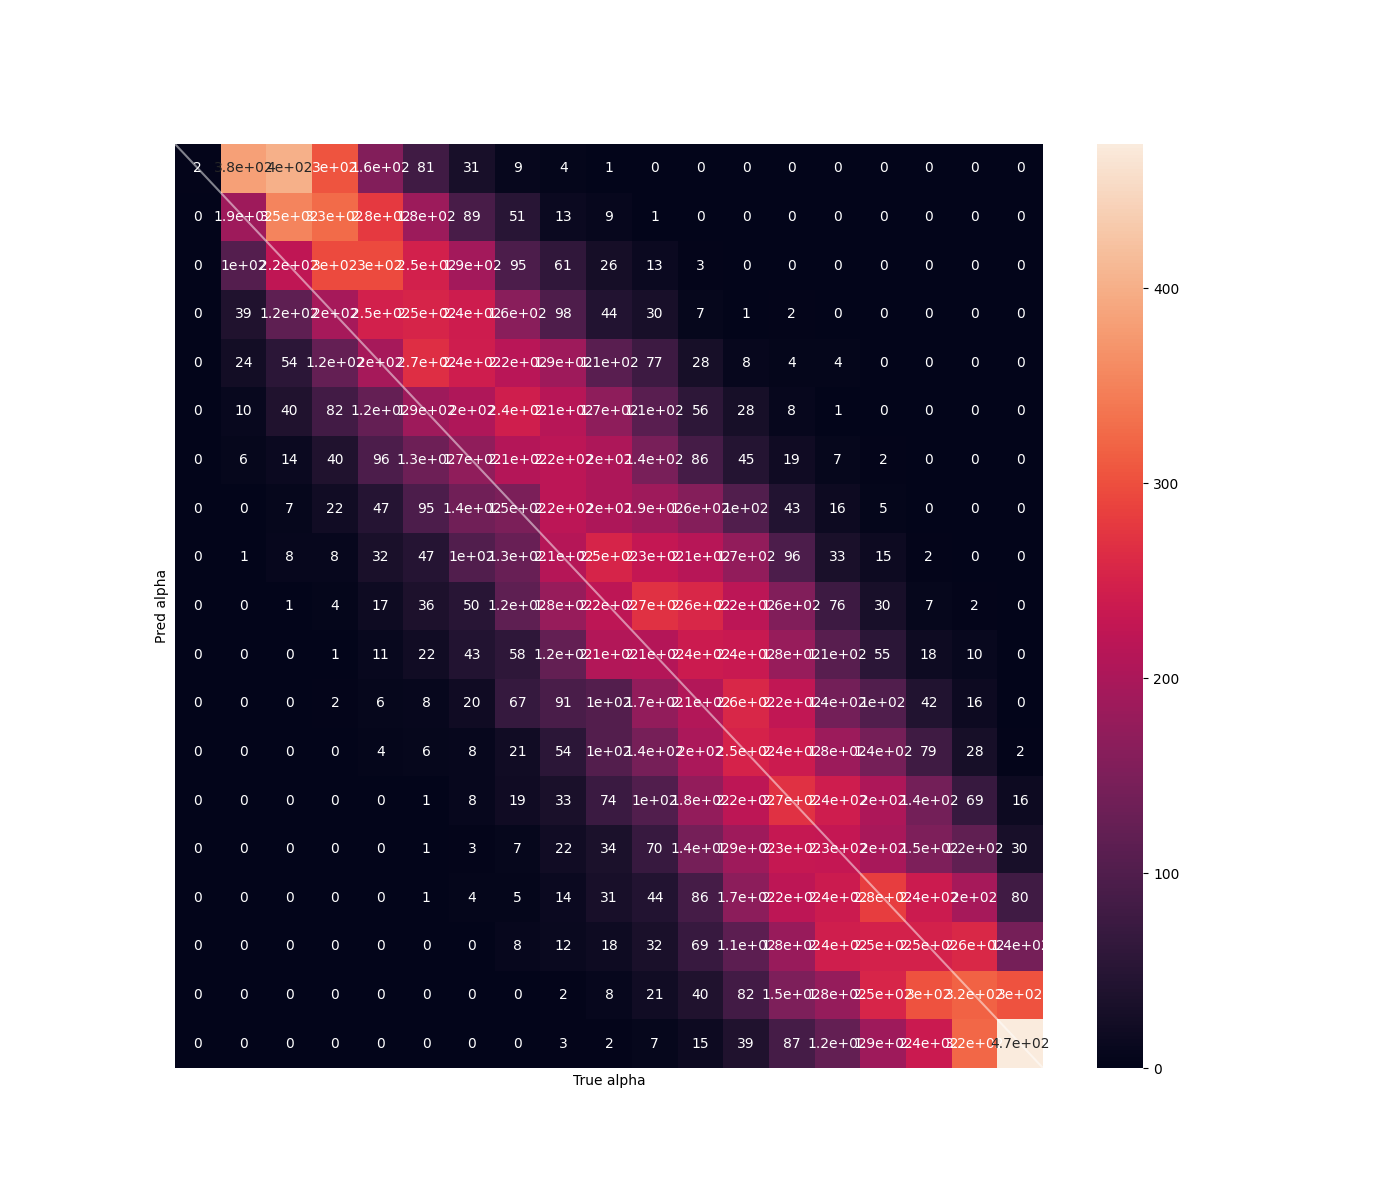

In [14]:
plt.figure(figsize=(14, 12))
ax = sns.heatmap(H, xticklabels=False, yticklabels=False, annot=True)
ax.plot([0, 255],[0, 255], c='white', alpha=0.5, *ax.get_xlim())
ax.set(xlabel='True alpha', ylabel='Pred alpha')